# Quantum Natural Language Processing Prototype
### Shengxin Zhuang (21463227)


### Data Processing

In [1]:
import gensim
import pandas as pd
import numpy as np

In [2]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = line[0]
            # labels.append([t, 1-t])
            labels.append(int(t))
            sentences.append(line[1:].strip())
    return labels, sentences

train_l, train_raw_data = read_data('../datasets/mc_train_data.txt')
dev_l, dev_raw_data = read_data('../datasets/mc_dev_data.txt')
test_l, test_raw_data = read_data('../datasets/mc_test_data.txt')

In [4]:
train_labels = np.array([train_l]).astype('float64').T
dev_labels   = np.array([dev_l]).astype('float64').T
test_labels   = np.array([test_l]).astype('float64').T

In [5]:
"""
* A raw text pre-processing method.
* This was adapted from a project from Lorenz et al. (2021) QNLP paper.
* From:
* https://github.com/CQCL/qnlp_lorenz_etal_2021_resources/blob/main/code/mc_task.ipynb
"""



vocab = dict()          # dictionary to be filled with the vocabulary in the form { word : POStag }
data  = dict()           # dictionary to be filled with all the data (train, dev and test subsets); entries of the 
                        # form { sentence : label } with label encoding '1' as [1.0, 0.0] and '0' as [0.0, 1.0]
training_data = []      # list of sentences in the train dataset as strings "word1 word2 ..."
dev_data      = []           # list of sentences in the dev dataset as strings "word1 word2 ..."
testing_data  = [] 

train_token = []
dev_token   = []
test_token  = []

for sent in train_raw_data:
    words = sent.split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    train_token.append(sentence.split())
    training_data.append(sentence)
    label = np.array([1.0, 0.0]) if sent[0] == '1' else np.array([0.0, 1.0])
    data[sentence] = label

# Go through the dev data
for sent in dev_raw_data:
    words = sent.split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    dev_token.append(sentence.split())
    dev_data.append(sentence)
    label = np.array([1.0, 0.0]) if sent[0] == '1' else np.array([0.0, 1.0])
    data[sentence] = label

for sent in test_raw_data:
    words = sent.split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    test_token.append(sentence.split())
    testing_data.append(sentence)
    label = np.array([1.0, 0.0]) if sent[0] == '1' else np.array([0.0, 1.0])
    data[sentence] = label

In [6]:
train_vec = []
test_vec = []

for sent in train_token:
    vec = []
    for word in sent:
        vec.append(wv[word])
    train_vec.append(vec)

for sent in test_token:
    vec = []
    for word in sent:
        vec.append(wv[word])
    test_vec.append(vec)

In [7]:
train_sent_vec = []
test_sent_vec = []

for sent in train_vec:
    all_vec = np.stack(sent,axis=0)
    sent_v = all_vec.mean(axis=0)
    train_sent_vec.append(sent_v)

for sent in test_vec:
    all_vec = np.stack(sent,axis=0)
    sent_v = all_vec.mean(axis=0)
    test_sent_vec.append(sent_v)

train_sent_vec = np.stack(train_sent_vec)
test_sent_vec = np.stack(test_sent_vec)

In [8]:
"""
* Truncated SVD 
* This was adapted from CITS4012 lab code
* From:
* https://weiliu2k.github.io/CITS4012/embeddings/svd.html
"""


import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
        # ------------------
        # Write your implementation here.
    M_r = sklearn.decomposition.TruncatedSVD(n_components=k,
                                           algorithm='randomized', 
                                           n_iter=n_iters, 
                                           random_state=None, 
                                           tol=0.0)
    M_reduced = M_r.fit_transform(M)
        # ------------------

    print("Done.")
    return M_reduced

In [9]:
kdim = 4
train_sent_vector = reduce_to_k_dim(train_sent_vec, kdim)
test_sent_vector = reduce_to_k_dim(test_sent_vec, kdim)

Running Truncated SVD over 70 words...
Done.
Running Truncated SVD over 30 words...
Done.


In [10]:
kn = 3
print(training_data[kn],train_sent_vector[kn],train_labels[kn])

man prepares meal [ 1.3699642   0.05085485  0.914163   -0.1359012 ] [1.]


## QNN Classifer

In [17]:
"""
*Quantum Classifer
*Following code were adapted from paddle quantum, institute for quantum computing, Baidu Inc.
*From:
*https://qml.baidu.com/tutorials/machine-learning/quantum-classifier.html
"""

# Import numpy and paddle
import numpy as np
import paddle

# To construct quantum circuit
from paddle_quantum.circuit import UAnsatz
# Some functions
from numpy import pi as PI
from paddle import matmul, transpose, reshape  # paddle matrix multiplication and transpose
from paddle_quantum.utils import pauli_str_to_matrix, dagger  # N qubits Pauli matrix, complex conjugate

# Plot figures, calculate the run time
from matplotlib import pyplot as plt
import time
from paddle_quantum.dataset import *

In [13]:
# Gate: rotate around Y-axis, Z-axis with angle theta
def Ry(theta):
    """
    :param theta: parameter
    :return: Y rotation matrix
    """
    return np.array([[np.cos(theta / 2), -np.sin(theta / 2)],
                     [np.sin(theta / 2), np.cos(theta / 2)]])

def Rz(theta):
    """
    :param theta: parameter
    :return: Z rotation matrix
    """
    return np.array([[np.cos(theta / 2) - np.sin(theta / 2) * 1j, 0],
                     [0, np.cos(theta / 2) + np.sin(theta / 2) * 1j]])

# Classical -> Quantum Data Encoder
def datapoints_transform_to_state(data, n_qubits):
    """
    :param data: shape [-1, 2]
    :param n_qubits: the number of qubits to which
    the data transformed
    :return: shape [-1, 1, 2 ^ n_qubits]
        the first parameter -1 in this shape means can be arbitrary. In this tutorial, it equals to BATCH.
    """
    dim1, dim2 = data.shape
    res = []
    for sam in range(dim1):
        res_state = 1.
        zero_state = np.array([[1, 0]])
        # Angle Encoding
        for i in range(n_qubits):
            # For even number qubits, perform Rz(arccos(x0^2)) Ry(arcsin(x0))
            if i % 2 == 0:
                state_tmp=np.dot(zero_state, Ry(np.arcsin(data[sam][0])).T)
                state_tmp=np.dot(state_tmp, Rz(np.arccos(data[sam][0] ** 2)).T)
                res_state=np.kron(res_state, state_tmp)
            # For odd number qubits, perform Rz(arccos(x1^2)) Ry(arcsin(x1))
            elif i% 2 == 1:
                state_tmp=np.dot(zero_state, Ry(np.arcsin(data[sam][1])).T)
                state_tmp=np.dot(state_tmp, Rz(np.arccos(data[sam][1] ** 2)).T)
                res_state=np.kron(res_state, state_tmp)
        res.append(res_state)
    res = np.array(res)

    return res.astype("complex128")

In [14]:
# Simulation of building a quantum neural network
def cir_Classifier(theta, n, depth):
    """
    :param theta: dim: [n, depth + 3], "+3" because we add an initial generalized rotation gate to each qubit
    :param n: number of qubits
    :param depth: circuit depth
    :return: U_theta
    """
    # Initialize the network
    cir = UAnsatz(n)
    
    # Build a generalized rotation layer
    for i in range(n):
        cir.rz(theta[i][0], i)
        cir.ry(theta[i][1], i)
        cir.rz(theta[i][2], i)

    # The default depth is depth = 1
    # Build the entangleed layer and Ry rotation layer
    for d in range(3, depth + 3):
        # The entanglement layer
        for i in range(n-1):
            cir.cnot([i, i + 1])
        cir.cnot([n-1, 0])
        # Add Ry to each qubit
        for i in range(n):
            cir.ry(theta[i][d], i)

    return cir

In [19]:
# Build the computational graph
class Opt_Classifier(paddle.nn.Layer):
    """
    Construct the model net
    """
    def __init__(self, n, depth, seed_paras=1, dtype='float64'):
        # Initialization, use n, depth give the initial PQC
        super(Opt_Classifier, self).__init__()
        self.n = n
        self.depth = depth
        # Initialize the parameters theta with a uniform distribution of [0, 2*pi]
        self.theta = self.create_parameter(
            shape=[n, depth + 3],  # "+3" because we add an initial generalized rotation gate to each qubit
            default_initializer=paddle.nn.initializer.Uniform(low=0.0, high=2*PI),
            dtype=dtype,
            is_bias=False)
        # Initialize bias
        self.bias = self.create_parameter(
            shape=[1],
            default_initializer=paddle.nn.initializer.Normal(std=0.01),
            dtype=dtype,
            is_bias=False)

    # Define forward propagation mechanism, and then calculate loss function and cross-validation accuracy
    def forward(self, state_in, label):
        """
        Args:
            state_in: The input quantum state, shape [-1, 1, 2^n] -- in this tutorial: [BATCH, 1, 2^n]
            label: label for the input state, shape [-1, 1]
        Returns:
            The loss:
                L = 1/BATCH * ((<Z> + 1)/2 + bias - label)^2
        """
        # Convert Numpy array to tensor
        Ob = paddle.to_tensor(Observable(self.n))
        label_pp = reshape(paddle.to_tensor(label), [-1, 1])

        # Build the quantum circuit
        cir = cir_Classifier(self.theta, n=self.n, depth=self.depth)
        Utheta = cir.U

        # Because Utheta is achieved by learning, we compute with row vectors to speed up without affecting the training effect
        state_out = matmul(state_in, Utheta)  # shape:[-1, 1, 2 ** n], the first parameter is BATCH in this tutorial

        # Measure the expectation value of Pauli Z operator <Z> -- shape [-1,1,1]
        E_Z = matmul(matmul(state_out, Ob), transpose(paddle.conj(state_out), perm=[0, 2, 1]))

        # Mapping <Z> to the estimated value of the label
        state_predict = paddle.real(E_Z)[:, 0] * 0.5 + 0.5 + self.bias  # |y^{i,k} - \tilde{y}^{i,k}|^2
        loss = paddle.mean((state_predict - label_pp) ** 2)  # Get average for "BATCH" |y^{i,k} - \tilde{y}^{i,k}|^2: L_i：shape:[1,1]

        # Calculate the accuracy of cross-validation
        is_correct = (paddle.abs(state_predict - label_pp) < 0.5).nonzero().shape[0]
        acc = is_correct / label.shape[0]

        return loss, acc, state_predict.numpy(), cir

In [15]:
# Generate Pauli Z operator that only acts on the first qubit
# Act the identity matrix on rest of the qubits
def Observable(n):
    r"""
    :param n: number of qubits
    :return: local observable: Z \otimes I \otimes ...\otimes I
    """
    Ob = pauli_str_to_matrix([[1.0,'z0']], n)

    return Ob

In [26]:
# A simpler classifier
def QClassifier2(quantum_train_x, train_y,quantum_test_x,test_y, N, DEPTH, EPOCH, LR, BATCH):
    """
    Quantum Binary Classifier
    Input：
        quantum_train_x     # training x
        train_y             # training y
        quantum_test_x      # testing x
        test_y              # testing y
        N                   # Number of qubits required
        DEPTH               # Circuit depth
        EPOCH               # Number of training epochs
        LR                  # Set the learning rate
        BATCH               # Batch size during training
    """
    Ntrain = len(quantum_train_x)
    
    paddle.seed(1)

    net = Opt_Classifier(n=N, depth=DEPTH)

    # Test accuracy list
    summary_iter, summary_test_acc = [], []

    # Adam can also be replaced by SGD or RMSprop
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

    # Optimize
    for ep in range(EPOCH):
        for itr in range(Ntrain // BATCH):
            # Import data
            input_state = quantum_train_x[itr * BATCH:(itr + 1) * BATCH]  # paddle.tensor
            input_state = reshape(input_state, [-1, 1, 2 ** N])
            label = train_y[itr * BATCH:(itr + 1) * BATCH]
            test_input_state = reshape(quantum_test_x, [-1, 1, 2 ** N])

            loss, train_acc, state_predict_useless, cir = net(state_in=input_state, label=label)
            # print(cir)
            # print('---------------------------------------------------------------')
            # if ep == 0 and itr == 0:
            #     print("Circuit before training:")
            #     print(cir)
            #     untrain_cir = cir
            if itr % 20 == 0:
                # get accuracy on test dataset (test_acc)
                loss_useless, test_acc, state_predict_useless, t_cir = net(state_in=test_input_state, label=test_y)
                print("epoch:", ep, "iter:", itr,
                      "loss: %.4f" % loss.numpy(),
                      "train acc: %.4f" % train_acc,
                      "test acc: %.4f" % test_acc)
                summary_test_acc.append(test_acc)

            loss.backward()
            opt.minimize(loss)
            opt.clear_grad()

    # print("Circuit before training:")
    # print(untrain_cir)

    print("The trained circuit:")
    print(cir)

    return summary_test_acc

## Training

epoch: 0 iter: 0 loss: 0.2847 train acc: 0.3286 test acc: 0.5333
epoch: 1 iter: 0 loss: 0.2805 train acc: 0.3857 test acc: 0.5333
epoch: 2 iter: 0 loss: 0.2766 train acc: 0.4143 test acc: 0.6000
epoch: 3 iter: 0 loss: 0.2731 train acc: 0.4000 test acc: 0.6000
epoch: 4 iter: 0 loss: 0.2700 train acc: 0.4286 test acc: 0.5333
epoch: 5 iter: 0 loss: 0.2672 train acc: 0.4857 test acc: 0.5000
epoch: 6 iter: 0 loss: 0.2647 train acc: 0.5143 test acc: 0.5333
epoch: 7 iter: 0 loss: 0.2626 train acc: 0.4857 test acc: 0.5667
epoch: 8 iter: 0 loss: 0.2607 train acc: 0.5000 test acc: 0.5667
epoch: 9 iter: 0 loss: 0.2590 train acc: 0.5571 test acc: 0.6000
epoch: 10 iter: 0 loss: 0.2576 train acc: 0.5429 test acc: 0.5667
epoch: 11 iter: 0 loss: 0.2562 train acc: 0.5714 test acc: 0.5667
epoch: 12 iter: 0 loss: 0.2549 train acc: 0.5714 test acc: 0.5667
epoch: 13 iter: 0 loss: 0.2537 train acc: 0.5714 test acc: 0.5667
epoch: 14 iter: 0 loss: 0.2524 train acc: 0.5714 test acc: 0.5667
epoch: 15 iter: 0 lo

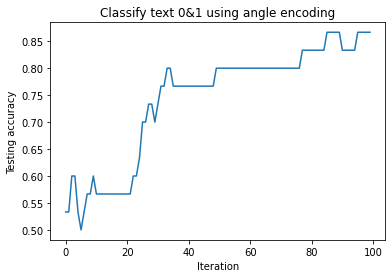

In [27]:

test_rate = 0.2
num_qubit = 4
dimension = 4
# acquire Iris data as quantum states
# iris =Iris (encoding='angle_encoding', num_qubits=num_qubit, test_rate=test_rate,classes=[0, 1], return_state=True)

# quantum_train_x, train_y = iris.train_x, iris.train_y
# quantum_test_x, test_y = iris.test_x, iris.test_y
# testing_data_num = len(test_y)
# training_data_num = len(train_y)
quantum_train_x= SimpleDataset(dimension).encode(train_sent_vector, 'angle_encoding', num_qubit)
quantum_test_x= SimpleDataset(dimension).encode(test_sent_vector, 'angle_encoding', num_qubit)
quantum_train_x = paddle.to_tensor(quantum_train_x)
quantum_test_x = paddle.to_tensor(quantum_test_x)
    

acc = QClassifier2(
        quantum_train_x, 
        train_labels,         
        quantum_test_x,  
        test_labels,          
        N = num_qubit,   
        DEPTH = 3,       
        EPOCH = 100,       
        LR = 0.01,        
        BATCH = 70,       
      )
plt.plot(acc)
plt.title("Classify text 0&1 using angle encoding")
plt.xlabel("Iteration")
plt.ylabel("Testing accuracy")
plt.show()

## Baselines
### SVM

In [28]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import pandas as pd

In [29]:
SVM = svm.SVC(gamma='auto')
SVM.fit(train_sent_vector,train_l)

SVC(gamma='auto')

In [30]:
predictions_SVM = SVM.predict(test_sent_vector)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, test_l)*100)

SVM Accuracy Score ->  100.0


In [31]:
svm_df ={'Prediction':predictions_SVM.tolist(),'Truth':test_l}

In [32]:
df=pd.DataFrame(svm_df)
df

,Prediction,Truth
0,1,1
1,1,1
2,0,0
3,1,1
4,1,1
5,0,0
6,0,0
7,0,0
8,1,1
9,1,1


### TextCnn

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

In [34]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=100, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(training_data).batch(128)
vectorizer.adapt(text_ds)

In [35]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [36]:
class_names=['IT','Food']

In [37]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if i >= 2:
        embedding_vector = wv[word]
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    
print("Converted %d words (%d misses)" % (hits, misses))

Converted 17 words (0 misses)


In [39]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [40]:
from tensorflow.keras import layers
# fz = 4
# ker =1

fz = 128
ker =5

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(fz, ker, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(fz, ker, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(fz, ker, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(fz, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         6300      
                                                                 
 conv1d (Conv1D)             (None, None, 128)         192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                         

#### Training

In [41]:
x_train = vectorizer(np.array([[s] for s in training_data])).numpy()
x_val = vectorizer(np.array([[s] for s in testing_data])).numpy()

y_train = np.array(train_l)
y_val = np.array(test_l)

In [42]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=70, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
1/1 [==============================] - 18s 18s/step - loss: 0.6946 - acc: 0.4857 - val_loss: 0.6658 - val_acc: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 32ms/step - loss: 0.6570 - acc: 0.6286 - val_loss: 0.5477 - val_acc: 0.8667
Epoch 3/20
1/1 [==============================] - 0s 32ms/step - loss: 0.5212 - acc: 0.9000 - val_loss: 0.3289 - val_acc: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 34ms/step - loss: 0.2906 - acc: 1.0000 - val_loss: 0.1389 - val_acc: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 33ms/step - loss: 0.1320 - acc: 1.0000 - val_loss: 0.0525 - val_acc: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 31ms/step - loss: 0.0603 - acc: 1.0000 - val_loss: 0.0348 - val_acc: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 33ms/step - loss: 0.0314 - acc: 1.0000 - val_loss: 0.0177 - val_acc: 1.0000
Epoch 8/20
1/1 [==============================] - 0s 31ms/step - loss: 0.0173 - acc: 1.0000 - val

#### Prediction

In [43]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

In [44]:
pred = []
for sent in dev_data:
    probabilities = end_to_end_model.predict([[sent]])
    pred.append(class_names[np.argmax(probabilities[0])])

1/1 [==============================] - 0s 27ms/step


In [45]:
# 0 it . 1 food
true = []
for ele in dev_l:
    if ele == 1:
        true.append('Food')
    else:
        true.append('IT')

In [46]:
cnn_df ={'Prediction':pred,'Truth':true}
cnn_df=pd.DataFrame(cnn_df)
cnn_df

,Prediction,Truth
0,IT,IT
1,Food,Food
2,Food,Food
3,Food,Food
4,IT,IT
5,IT,IT
6,Food,Food
7,Food,Food
8,IT,IT
9,IT,IT
